In [1]:
!pip install torch-scatter -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-cluster -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-spline-conv -q -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric -q

     |████████████████████████████████| 7.9 MB 2.5 MB/s 
     |████████████████████████████████| 3.5 MB 2.8 MB/s 
     |████████████████████████████████| 2.3 MB 2.8 MB/s 
     |████████████████████████████████| 747 kB 2.0 MB/s 
     |████████████████████████████████| 370 kB 5.2 MB/s 
     |████████████████████████████████| 482 kB 60.0 MB/s 
     |████████████████████████████████| 41 kB 736 kB/s 


In [2]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, DataLoader

import scipy.sparse as sp

# Download Dataset

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/ML on graph/Project

/content/drive/MyDrive/ML on graph/Project


In [ ]:
!kaggle datasets download ellipticco/elliptic-data-set

 99% 144M/146M [00:01<00:00, 57.2MB/s]
100% 146M/146M [00:01<00:00, 84.1MB/s]


In [ ]:
!unzip elliptic-data-set.zip

Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


# Load & Prepare Data

In [3]:
%cd /content/drive/MyDrive/ML on graph/Project

/content/drive/MyDrive/ML on graph/Project


In [4]:
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_classes =  pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

In [5]:
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# Convert Dataset to torch_geometric.data.Data object

In [6]:
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0).sort_values(0).reset_index(drop=True)
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = torch.tensor(edges.values, dtype=torch.long).contiguous().T
#weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

torch.Size([2, 234355])


In [7]:
# maping txIds to corresponding indexes, to pass node features to the model
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)
classified_idx = node_features[node_features['class'] != 2].index
unclassified_idx = node_features[node_features['class'] == 2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0) 

In [8]:
X = torch.tensor(node_features.drop([0, 'class', 1], axis=1).values, dtype=torch.double)

# TRY THIS
# X = torch.tensor(node_features.drop([0, 'class'], axis=1).values, dtype=torch.double)

Y = torch.tensor(node_features['class'].values, dtype=torch.double)

In [9]:
# converting data to PyGeometric graph data format

data_train = Data(x=X,
                  edge_index=edge_index,
                  y=Y
                )

In [10]:
# spliting train set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_val, train_idx, val_idx = train_test_split(X[classified_idx], 
                                                                        Y[classified_idx], 
                                                                        classified_idx,
                                                                        test_size=0.15,
                                                                        random_state=2022,
                                                                        stratify=Y[classified_idx]
                                                                        )

# GCN Architecture

In [11]:
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GCNConv(input_dim, hidden_dim))
        for i in range(num_layers - 2):
          self.convs.append(GCNConv(hidden_dim, hidden_dim))
        self.convs.append(GCNConv(hidden_dim, output_dim))

        for i in range(num_layers - 1):
          self.bns.append(torch.nn.BatchNorm1d(num_features=hidden_dim))

        # Probability of an element getting zeroed
        self.dropout = dropout


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        for conv, bn in zip(self.convs[:-1], self.bns):
          x = F.relu(bn(conv(x, edge_index)))
          if self.training:
            x = F.dropout(x, p=self.dropout)
            
        x = self.convs[-1](x, edge_index)
        out = torch.sigmoid(x)

        return out

In [12]:
def train(model, data_train, train_idx, optimizer, loss_fn, scheduler):
    
  model.train()
  optimizer.zero_grad()
  pred = model(data_train)
  pred = pred.reshape((data_train.x.shape[0]))
  train_loss = loss_fn(pred[train_idx], data_train.y[train_idx])

  train_loss.backward()
  optimizer.step()
  
  
  val_loss = loss_fn(pred[val_idx], data_train.y[val_idx])
  scheduler.step(val_loss)

  return pred, train_loss.item(), val_loss.item()

## Train

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
      'num_layers': 3,
      'hidden_dim': 128,
      'dropout': 0.4,
      'lr': 0.01,
      'epochs': 300,
      }

In [19]:
model = GCN(input_dim=data_train.num_features,
            hidden_dim=args['hidden_dim'],
            output_dim=1,
            num_layers=args['num_layers'],
            dropout=args['dropout'],
            ).to(device)

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

model.reset_parameters()
model.double()
data_train = data_train.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.8, min_lr=0.0001)
loss_fn = torch.nn.BCELoss()

best_model = None
best_valid_loss = 10
train_losses = []
valid_losses = []
epoch_ls = []

for epoch in range(1, 1 + args["epochs"]):

  pred, train_loss, val_loss = train(model, data_train, train_idx, optimizer, loss_fn, scheduler)
  out_labels = pred.detach().cpu().numpy() > 0.5

  # Metrics
  train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
  train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], pred.detach().cpu().numpy()[train_idx])

  valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
  valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[val_idx], pred.detach().cpu().numpy()[val_idx])

  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    best_valid_acc = valid_acc
    best_valid_auc = valid_auc
    best_model = copy.deepcopy(model)

  if epoch%5 == 0:
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    epoch_ls.append(epoch)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train_Accuracy: {100 * train_acc:.2f}%, '
          f'Train_AUC: {100 * train_auc:.2f}%, '
          f'Valid_Loss: {val_loss:.4f}, '
          f'Valid_Accuracy: {100 * valid_acc:.2f}% '
          f'Valid_AUC: {100 * valid_auc:.2f}% ')

Epoch: 05, Loss: 0.3057, Train_Accuracy: 86.47%, Train_AUC: 83.09%, Valid_Loss: 0.3084, Valid_Accuracy: 86.27% Valid_AUC: 82.99% 
Epoch: 10, Loss: 0.2546, Train_Accuracy: 90.37%, Train_AUC: 84.48%, Valid_Loss: 0.2501, Valid_Accuracy: 90.34% Valid_AUC: 85.09% 
Epoch: 15, Loss: 0.2315, Train_Accuracy: 91.09%, Train_AUC: 88.22%, Valid_Loss: 0.2350, Valid_Accuracy: 91.15% Valid_AUC: 88.19% 
Epoch: 20, Loss: 0.2173, Train_Accuracy: 92.05%, Train_AUC: 90.11%, Valid_Loss: 0.2274, Valid_Accuracy: 91.98% Valid_AUC: 89.70% 
Epoch: 25, Loss: 0.2100, Train_Accuracy: 92.80%, Train_AUC: 90.72%, Valid_Loss: 0.2206, Valid_Accuracy: 92.71% Valid_AUC: 90.28% 
Epoch: 30, Loss: 0.2000, Train_Accuracy: 93.08%, Train_AUC: 91.43%, Valid_Loss: 0.2143, Valid_Accuracy: 93.09% Valid_AUC: 90.81% 
Epoch: 35, Loss: 0.1924, Train_Accuracy: 93.15%, Train_AUC: 91.94%, Valid_Loss: 0.2074, Valid_Accuracy: 92.90% Valid_AUC: 91.15% 
Epoch: 40, Loss: 0.1835, Train_Accuracy: 93.56%, Train_AUC: 92.57%, Valid_Loss: 0.1979, Va

In [21]:
path = '/content/drive/My Drive/ML on graph/Project/modelweights'
torch.save(best_model.state_dict(), path)
print(f"Best model state_dict saved in {path}")

Best model state_dict saved in /content/drive/My Drive/ML on graph/Project/modelweights


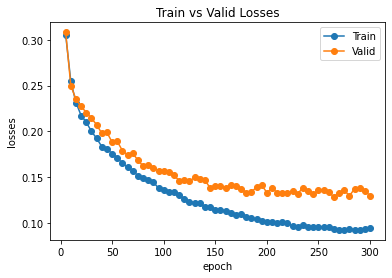

In [22]:
import matplotlib.pyplot as plt

plt.plot(epoch_ls, train_losses, '-o')
plt.plot(epoch_ls, valid_losses, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

## Evaluation

In [26]:
print(f'Valid_Loss: {best_valid_loss:.4f} Valid_Accuracy: {100 * best_valid_acc:.2f} Valid_AUC: {100 * best_valid_auc:.2f}')

Valid_Loss: 0.1287 Valid_Accuracy: 95.55 Valid_AUC: 96.33


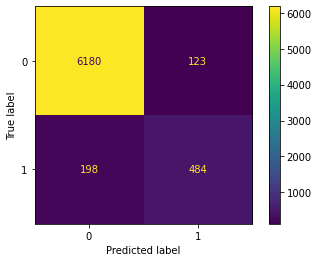

In [27]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
CM_disp = ConfusionMatrixDisplay(cm)
CM_disp.plot()

# GAT Architecture

In [28]:
import torch.nn.functional as F

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GAT, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(GATConv(input_dim, hidden_dim))
        for i in range(num_layers - 2):
          self.convs.append(GATConv(hidden_dim, hidden_dim))
        self.convs.append(GATConv(hidden_dim, output_dim))

        for i in range(num_layers - 1):
          self.bns.append(torch.nn.BatchNorm1d(num_features=hidden_dim))

        # Probability of an element getting zeroed
        self.dropout = dropout


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        for conv, bn in zip(self.convs[:-1], self.bns):
          x = F.relu(bn(conv(x, edge_index)))
          if self.training:
            x = F.dropout(x, p=self.dropout)
            
        x = self.convs[-1](x, edge_index)
        out = torch.sigmoid(x)

        return out

In [29]:
def train(model, data_train, train_idx, optimizer, loss_fn, scheduler):
    
  model.train()
  optimizer.zero_grad()
  pred = model(data_train)
  pred = pred.reshape((data_train.x.shape[0]))
  train_loss = loss_fn(pred[train_idx], data_train.y[train_idx])

  train_loss.backward()
  optimizer.step()
  
  
  val_loss = loss_fn(pred[val_idx], data_train.y[val_idx])
  scheduler.step(val_loss)

  return pred, train_loss.item(), val_loss.item()

## Train

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
      'num_layers': 3,
      'hidden_dim': 128,
      'dropout': 0.4,
      'lr': 0.01,
      'epochs': 300,
      }

In [31]:
model = GAT(input_dim=data_train.num_features,
            hidden_dim=args['hidden_dim'],
            output_dim=1,
            num_layers=args['num_layers'],
            dropout=args['dropout'],
            ).to(device)

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

model.reset_parameters()
model.double()
data_train = data_train.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.8, min_lr=0.0001)
loss_fn = torch.nn.BCELoss()

best_model = None
best_valid_loss = 10
train_losses = []
valid_losses = []
epoch_ls = []

for epoch in range(1, 1 + args["epochs"]):

  pred, train_loss, val_loss = train(model, data_train, train_idx, optimizer, loss_fn, scheduler)
  out_labels = pred.detach().cpu().numpy() > 0.5

  # Metrics
  train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
  train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], pred.detach().cpu().numpy()[train_idx])

  valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
  valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[val_idx], pred.detach().cpu().numpy()[val_idx])

  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    best_valid_acc = valid_acc
    best_valid_auc = valid_auc
    best_model = copy.deepcopy(model)

  if epoch%5 == 0:
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    epoch_ls.append(epoch)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train_Accuracy: {100 * train_acc:.2f}%, '
          f'Train_AUC: {100 * train_auc:.2f}%, '
          f'Valid_Loss: {val_loss:.4f}, '
          f'Valid_Accuracy: {100 * valid_acc:.2f}% '
          f'Valid_AUC: {100 * valid_auc:.2f}% ')

Epoch: 05, Loss: 0.2497, Train_Accuracy: 90.65%, Train_AUC: 86.13%, Valid_Loss: 0.2532, Valid_Accuracy: 90.38% Valid_AUC: 86.02% 
Epoch: 10, Loss: 0.2225, Train_Accuracy: 91.29%, Train_AUC: 88.99%, Valid_Loss: 0.2274, Valid_Accuracy: 91.17% Valid_AUC: 88.51% 
Epoch: 15, Loss: 0.2029, Train_Accuracy: 92.54%, Train_AUC: 91.12%, Valid_Loss: 0.2138, Valid_Accuracy: 92.31% Valid_AUC: 90.49% 
Epoch: 20, Loss: 0.1913, Train_Accuracy: 93.66%, Train_AUC: 92.19%, Valid_Loss: 0.2048, Valid_Accuracy: 93.40% Valid_AUC: 91.38% 
Epoch: 25, Loss: 0.1827, Train_Accuracy: 93.65%, Train_AUC: 92.87%, Valid_Loss: 0.1958, Valid_Accuracy: 93.74% Valid_AUC: 91.78% 
Epoch: 30, Loss: 0.1708, Train_Accuracy: 94.11%, Train_AUC: 93.54%, Valid_Loss: 0.1855, Valid_Accuracy: 93.70% Valid_AUC: 92.15% 
Epoch: 35, Loss: 0.1649, Train_Accuracy: 94.65%, Train_AUC: 93.98%, Valid_Loss: 0.1804, Valid_Accuracy: 94.29% Valid_AUC: 92.76% 
Epoch: 40, Loss: 0.1541, Train_Accuracy: 94.76%, Train_AUC: 94.65%, Valid_Loss: 0.1702, Va

In [ ]:
path = '/content/drive/My Drive/ML on graph/Project/modelweights'
torch.save(best_model.state_dict(), path)
print(f"Best model state_dict saved in {path}")

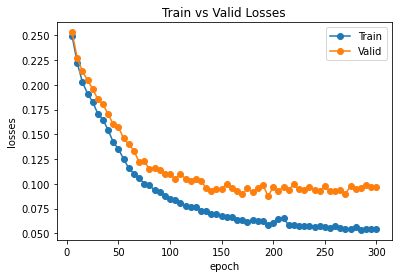

In [34]:
import matplotlib.pyplot as plt

plt.plot(epoch_ls, train_losses, '-o')
plt.plot(epoch_ls, valid_losses, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

## Evaluation

In [35]:
print(f'Valid_Loss: {best_valid_loss:.4f} Valid_Accuracy: {100 * best_valid_acc:.2f} Valid_AUC: {100 * best_valid_auc:.2f}')

Valid_Loss: 0.0872 Valid_Accuracy: 97.07 Valid_AUC: 98.10


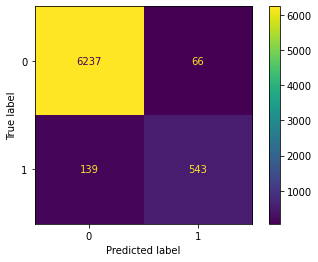

In [36]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
CM_disp = ConfusionMatrixDisplay(cm)
CM_disp.plot()

# GraphSAGE Architecture

In [37]:
import torch.nn.functional as F

class GSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GSAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        for i in range(num_layers - 2):
          self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        for i in range(num_layers - 1):
          self.bns.append(torch.nn.BatchNorm1d(num_features=hidden_dim))

        # Probability of an element getting zeroed
        self.dropout = dropout


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        for conv, bn in zip(self.convs[:-1], self.bns):
          x = F.relu(bn(conv(x, edge_index)))
          if self.training:
            x = F.dropout(x, p=self.dropout)
            
        x = self.convs[-1](x, edge_index)
        out = torch.sigmoid(x)

        return out

In [38]:
def train(model, data_train, train_idx, optimizer, loss_fn, scheduler):
    
  model.train()
  optimizer.zero_grad()
  pred = model(data_train)
  pred = pred.reshape((data_train.x.shape[0]))
  train_loss = loss_fn(pred[train_idx], data_train.y[train_idx])

  train_loss.backward()
  optimizer.step()
  
  
  val_loss = loss_fn(pred[val_idx], data_train.y[val_idx])
  scheduler.step(val_loss)

  return pred, train_loss.item(), val_loss.item()

## Train

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
      'num_layers': 3,
      'hidden_dim': 128,
      'dropout': 0.4,
      'lr': 0.01,
      'epochs': 300,
      }

In [40]:
model = GSAGE(input_dim=data_train.num_features,
            hidden_dim=args['hidden_dim'],
            output_dim=1,
            num_layers=args['num_layers'],
            dropout=args['dropout'],
            ).to(device)

In [41]:
from sklearn.metrics import roc_auc_score, accuracy_score
import copy

model.reset_parameters()
model.double()
data_train = data_train.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.8, min_lr=0.0001)
loss_fn = torch.nn.BCELoss()

best_model = None
best_valid_loss = 10
train_losses = []
valid_losses = []
epoch_ls = []

for epoch in range(1, 1 + args["epochs"]):

  pred, train_loss, val_loss = train(model, data_train, train_idx, optimizer, loss_fn, scheduler)
  out_labels = pred.detach().cpu().numpy() > 0.5

  # Metrics
  train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
  train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], pred.detach().cpu().numpy()[train_idx])

  valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
  valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[val_idx], pred.detach().cpu().numpy()[val_idx])


  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    best_valid_acc = valid_acc
    best_valid_auc = valid_auc
    best_model = copy.deepcopy(model)

  if epoch%5 == 0:
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    epoch_ls.append(epoch)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train_Accuracy: {100 * train_acc:.2f}%, '
          f'Train_AUC: {100 * train_auc:.2f}%, '
          f'Valid_Loss: {val_loss:.4f}, '
          f'Valid_Accuracy: {100 * valid_acc:.2f}% '
          f'Valid_AUC: {100 * valid_auc:.2f}% ')

Epoch: 05, Loss: 0.2560, Train_Accuracy: 90.24%, Train_AUC: 84.23%, Valid_Loss: 0.2604, Valid_Accuracy: 90.26% Valid_AUC: 84.00% 
Epoch: 10, Loss: 0.2116, Train_Accuracy: 90.30%, Train_AUC: 91.63%, Valid_Loss: 0.2174, Valid_Accuracy: 90.28% Valid_AUC: 91.07% 
Epoch: 15, Loss: 0.1885, Train_Accuracy: 90.89%, Train_AUC: 93.37%, Valid_Loss: 0.1955, Valid_Accuracy: 90.82% Valid_AUC: 92.74% 
Epoch: 20, Loss: 0.1732, Train_Accuracy: 92.59%, Train_AUC: 94.40%, Valid_Loss: 0.1849, Valid_Accuracy: 92.30% Valid_AUC: 93.40% 
Epoch: 25, Loss: 0.1593, Train_Accuracy: 94.17%, Train_AUC: 94.93%, Valid_Loss: 0.1688, Valid_Accuracy: 94.20% Valid_AUC: 94.22% 
Epoch: 30, Loss: 0.1414, Train_Accuracy: 95.21%, Train_AUC: 95.91%, Valid_Loss: 0.1503, Valid_Accuracy: 94.95% Valid_AUC: 95.24% 
Epoch: 35, Loss: 0.1313, Train_Accuracy: 95.59%, Train_AUC: 96.22%, Valid_Loss: 0.1409, Valid_Accuracy: 95.29% Valid_AUC: 95.66% 
Epoch: 40, Loss: 0.1190, Train_Accuracy: 96.07%, Train_AUC: 96.78%, Valid_Loss: 0.1283, Va

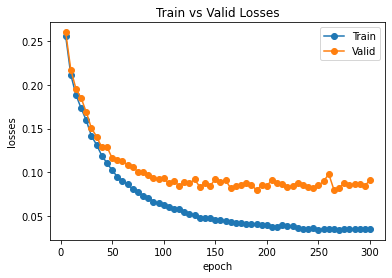

In [42]:
import matplotlib.pyplot as plt

plt.plot(epoch_ls, train_losses, '-o')
plt.plot(epoch_ls, valid_losses, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

## Evaluation

In [43]:
print(f'Valid_Loss: {best_valid_loss:.4f} Valid_Accuracy: {100 * best_valid_acc:.2f} Valid_AUC: {100 * best_valid_auc:.2f}')

Valid_Loss: 0.0764 Valid_Accuracy: 97.64 Valid_AUC: 98.47


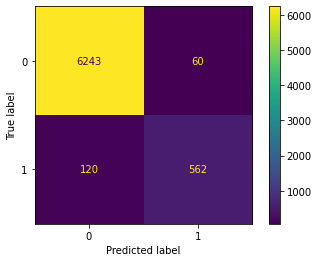

In [44]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[val_idx], out_labels[val_idx])
CM_disp = ConfusionMatrixDisplay(cm)
CM_disp.plot()